In [ ]:
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from astropy.table import MaskedColumn
import matplotlib.pyplot as plt
import numpy.linalg as la
import math
import astropy.io.fits as fits
import scipy.ndimage as ndimage
from astropy.convolution import convolve as ap_convolve
from astropy.convolution import convolve_fft
from astropy.convolution import Box2DKernel
from scipy import fftpack
import copy
from astropy.convolution import Gaussian2DKernel
from skimage.restoration import richardson_lucy

In [ ]:
stars = ["delcep", "etaaql", "rspup","rtaur","ssge","svul","uvul","wsgr","xcyg","zetgem"]
data = {}
for i in stars:
  data[i] = Table(ascii.read("/content/aavso_"+i+".dat"), masked = True)
  data_mask = (data[i]["Band"] != "Vis.") | (data[i]["JD"] < 2440000)
  data[i]["JD"].mask = data_mask
  data[i]["Magnitude"].mask = data_mask

In [ ]:
interp = {}
for i in stars:
  interp[i] = np.interp(np.arange(np.floor(np.min(data[i]["JD"])), np.round(np.max(data[i]["JD"])) + 1, 1), data[i]["JD"], data[i]["Magnitude"])
  print(interp[i])

[3.88965517 3.86666667 3.81036269 ... 3.65219433 3.91311381 4.56905312]
[3.7        3.66124808 3.60833    ... 4.08801854 3.86887048 3.65      ]
[7.2        7.19981629 7.19920392 ... 7.42816193 7.40592941 7.4       ]
[5.4        5.38931624 5.37863248 ... 5.88639629 5.81841054 5.22069513]
[6.         5.99960921 5.99830656 ... 5.64426344 5.64776326 5.65      ]
[9.6        9.69       9.99       ... 9.07232704 9.08490566 9.09748428]
[7.4        7.3995396  7.39856002 ... 7.21709453 7.24846346 7.35075904]
[4.90494341 5.26879699 5.95651403 ... 4.72215268 4.7540534  4.78595411]
[6.         6.045      6.195      ... 6.76952334 6.78569965 6.8       ]
[3.9        3.9        3.9        ... 3.77828657 3.72465461 3.85297991]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32:

[ 5.36819728  7.17312073 41.47333333  3.72905526  8.38748336 68.31521739
  7.9869186   7.59587379 16.36623377 10.15072934]


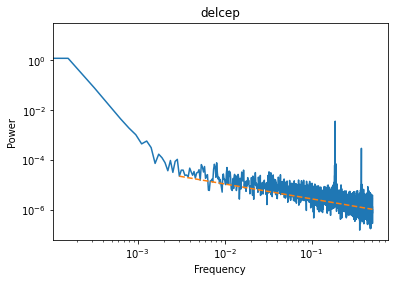

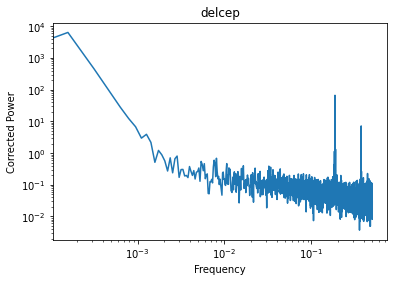

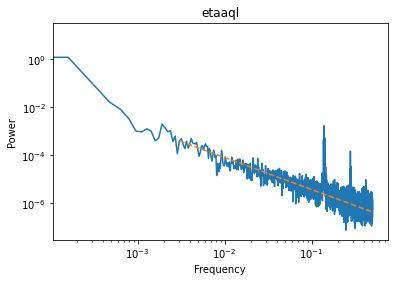

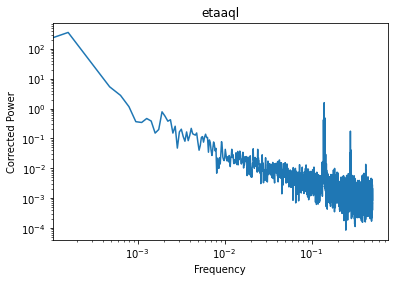

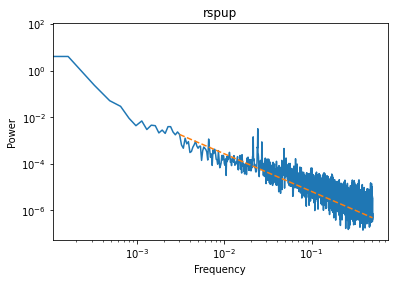

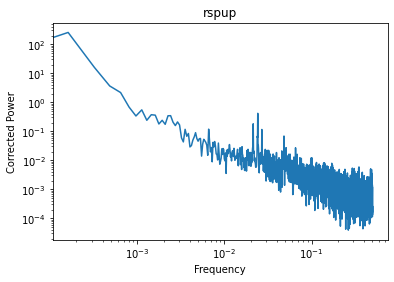

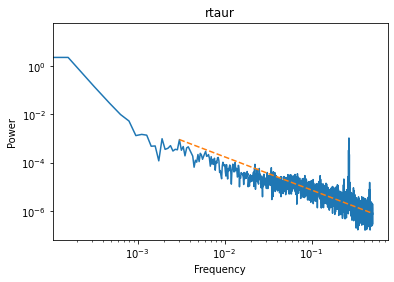

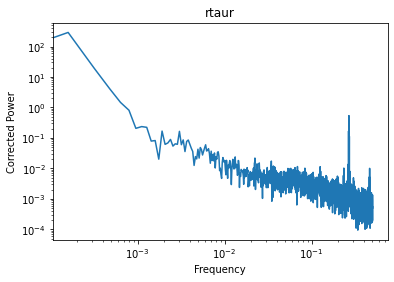

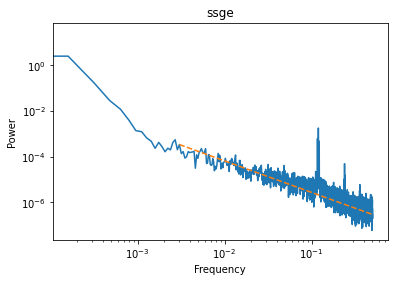

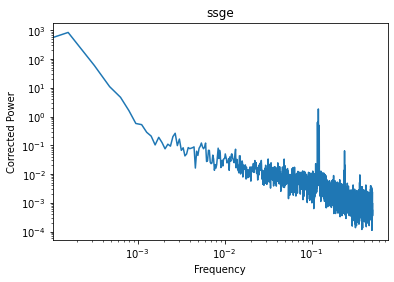

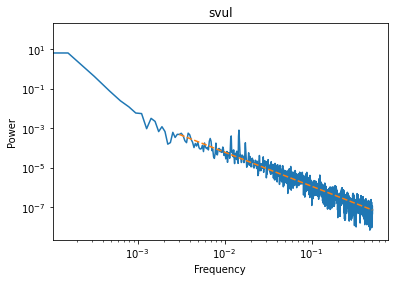

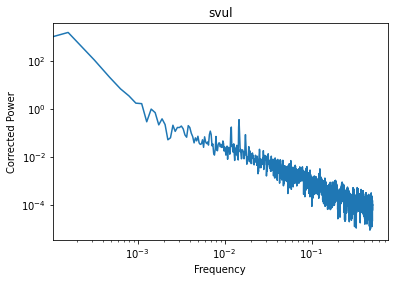

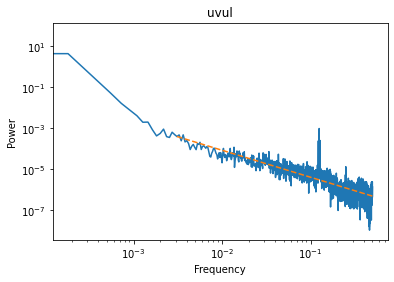

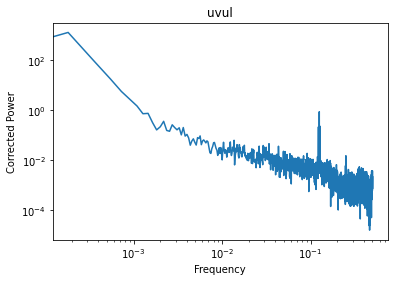

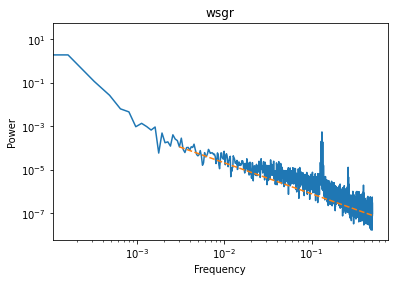

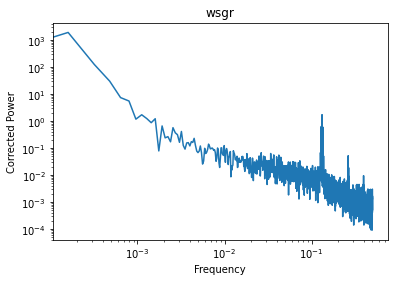

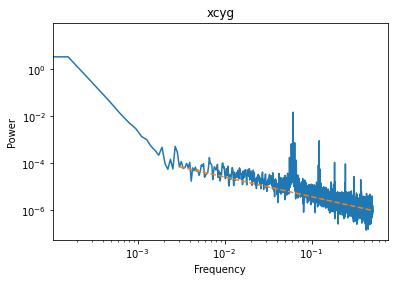

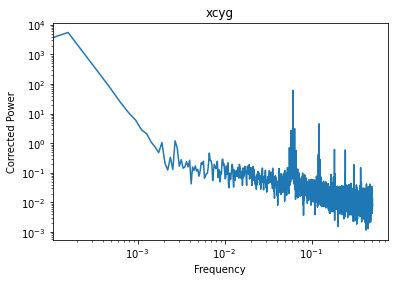

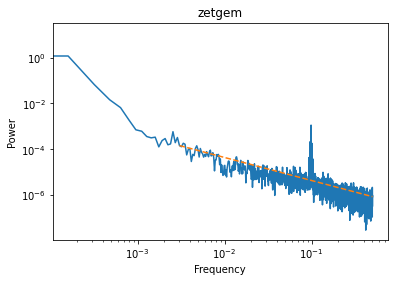

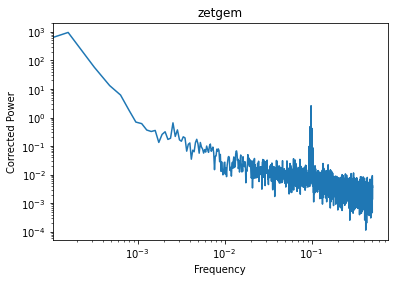

In [ ]:
def Welch(n):
  return 1. - ((np.arange(n) - n / 2) / (n / 2)) ** 2
period = []
for i in stars:
  K = 5
  Nseg = 2 * len(interp[i]) // (K+1)
  sample_interval = 1
  f = np.fft.rfftfreq(Nseg,sample_interval)
  p= np.zeros(Nseg//2+1)
  for j in range(K):
    snhat = np.fft.rfft(Welch(Nseg)*interp[i][j*Nseg//2:j*Nseg//2+Nseg])
    p = p + np.abs(snhat)**2 / (Nseg*np.sum(Welch(Nseg)**2))
  p = p / K
  plt.figure()
  plt.loglog(f, p)
  plt.xlabel("Frequency")
  plt.ylabel("Power")
  plt.title(i)
  index = 0
  
  smallest_freq = np.inf
  
  for k in range(len(f)):
    if (f[k] > 0.003) and (f[k] < smallest_freq):
      index = k
      smallest_freq = f[k]
    
  plt.plot([f[index], f[-1]], [p[index], p[-1]], "--")
  plt.savefig(i+'.png')
  k_b = np.polyfit([f[index], f[-1]], [p[index], p[-1]], 1)
  c_p = p/(k_b[0] * np.log10(f)+k_b[1])
  largest_power = -1
  largest_index = 0
  for k in range(len(f)):
    if (f[k] > 0.003) and (p[k] > largest_power):
      largeIndex = k
      largest_power = p[k]
  plt.figure()
  plt.loglog(f, c_p)
  plt.xlabel("Frequency")
  plt.ylabel("Corrected Power")
  plt.title(i)
  plt.savefig("corrected" +i+'.png')
  if np.max(f) > 0.003:
    period.append(1/f[largeIndex])
period = np.array(period)
print(period)

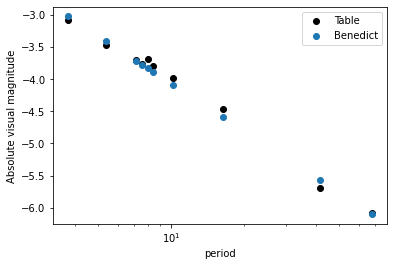

In [ ]:
plt.figure()
stars = ["delcep", "etaaql", "rspup","rtaur","ssge","svul","uvul","wsgr","xcyg","zetgem"]
mv_t = ([-3.47, -3.70,-5.7, -3.09, -3.8, -6.08, -3.69, -3.76, -4.46, -3.99])
mv_b = -2.43*(np.log10(period)-1)-(4.05+0.02)
plt.scatter(period, mv_t, label = "Table", color = "black", marker = "o")
plt.scatter(period, mv_b, label = "Benedict")
plt.xlabel("period")
plt.ylabel("Absolute visual magnitude")
plt.xscale("log")
plt.legend()

Text(0.5, 1.0, 'W SGR ')

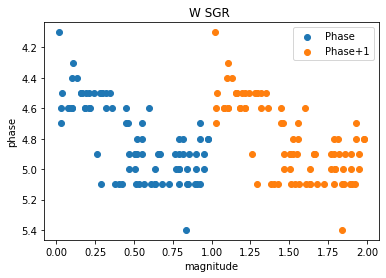

In [ ]:
mag = []
jd = []
for i in range(len(data["wsgr"]["JD"])):
  if data["wsgr"]["JD"][i] >= 2458500 and data["wsgr"]["Observer Affiliation"][i] == "AAVSO" and data["wsgr"]["Measurement Method"][i] == "STD":
    mag.append(data["wsgr"]["Magnitude"][i])
    jd.append(data["wsgr"]["JD"][i])
jd = np.array(jd)
mag = np.array(mag)
phase = (jd/period[7]) %1
plt.figure()
plt.scatter(phase, mag, label="Phase")
plt.scatter(phase + 1, mag,label="Phase+1")
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("magnitude")
plt.ylabel("phase")
plt.title("W SGR ")

In [ ]:
hdulist = fits.open("L18_lmc.ha.b20.fits")
hdr = hdulist[0].header
img = hdulist[0].data
n1 = hdr['NAXIS1']
n2 = hdr['NAXIS2']
dx= hdr['xPIXSIZE']
dy= hdr['YPIXSIZE']

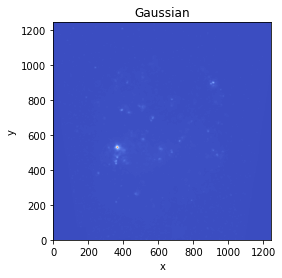

In [ ]:
plt.figure()
plt.imshow(ndimage.gaussian_filter(img,1), origin = "lower", extent = [0, n1*dx, 0, n2*dy])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gaussian")
plt.set_cmap('coolwarm')

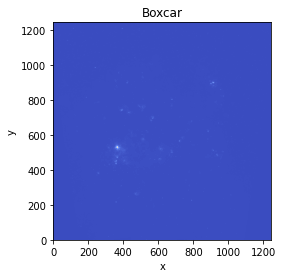

In [ ]:
# setup our kernel
box_kernel = Box2DKernel(1)
# perform convolution
result = ap_convolve(img, box_kernel, normalize_kernel=True)
plt.figure()
plt.imshow(result, origin = "lower", extent = [0, n1*dx, 0, n2*dy])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Boxcar")
plt.set_cmap('coolwarm')

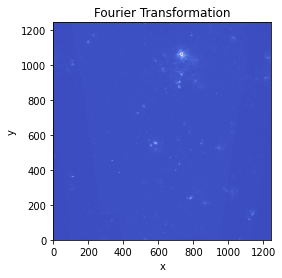

In [ ]:
img_f = np.fft.rfft2(img)
img_f = img_f[::2, ::2]
imgg = np.fft.irfft2(img_f)
plt.figure()
plt.imshow(imgg, origin = "lower", extent = [0, n1*dx, 0, n2*dy])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fourier Transformation")
plt.set_cmap('coolwarm')